In [1]:
import pandas as pd
from rdflib import Graph
from rdflib.plugins.sparql.processor import SPARQLResult

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
path = 'KG/'

g1 = Graph()
g1.parse(path + "G1.ttl", format="ttl")

g2 = Graph()
g2.parse(path + "G2.ttl", format="ttl")

<Graph identifier=N19ecf081d9c24b638a9514af48892d04 (<class 'rdflib.graph.Graph'>)>

In [3]:
def query_treatment_ddi():
    query = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX ex: <http://example/#> 

    select distinct ?treatment ?class (count(?ddi) as ?count_ddi)
    where {
        ?treatment rdf:type ex:Treatment .
        ?treatment ex:belong_to ?class .
        optional {?treatment ex:hasInteraction ?ddi .}
        }
        GROUP BY ?treatment
        ORDER BY desc(?count_ddi)
        """
    return query

def query_treatment_ddi_plot(target):
    query = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX ex: <http://example/#> 

    select distinct ?treatment  (count(?ddi) as ?count_ddi)
    where {
        ?treatment rdf:type ex:Treatment .
        ?treatment ex:belong_to """+target+""" .
        optional {?treatment ex:hasInteraction ?ddi .}
        }
        GROUP BY ?treatment
        ORDER BY desc(?count_ddi)
        """
    return query


def sparql_results_to_df(results: SPARQLResult) -> pd.DataFrame:
    """
    Export results from an rdflib SPARQL query into a `pandas.DataFrame`,
    using Python types. See https://github.com/RDFLib/rdflib/issues/1179.
    """
    return pd.DataFrame(
        data=([None if x is None else x.toPython() for x in row] for row in results),
        columns=[str(x) for x in results.vars],
    )

def density_ddi(df_plot):
    col = [mcolors.CSS4_COLORS['rosybrown'], mcolors.CSS4_COLORS['lightcoral'], mcolors.CSS4_COLORS['brown']]
    fig, ax = plt.subplots()
    sns.kdeplot(data=df_plot['KG1'], ax=ax, fill=True, shade=True,
                cut=0, bw_adjust=.4, label='${\cal{T\_KG}}_{basic}$')
    sns.kdeplot(data=df_plot['KG2'], ax=ax, fill=True, shade=True,
                cut=0, bw_adjust=.4, label='$\cal{T\_KG}$')
    #sns.kdeplot(data=df_plot['KG3'], ax=ax, fill=True, shade=True,
    #            cut=0, bw_adjust=.4, label='${\cal{T\_KG}}_{random}$')

    ax.legend( loc='upper right') #bbox_to_anchor=(1.02, 1.02),
    ax.set_xlabel('Count of DDIs')
    plt.title('Density of DDIs by Effective Treatment')
    plt.tight_layout()
    #plt.savefig('Plots/Density_effective_treatment.pdf', format='pdf', bbox_inches='tight')

## Number of DDIs by treatment

In [4]:
qres = g1.query(query_treatment_ddi())
t_ddi = sparql_results_to_df(qres)
t_ddi

treatment                       class  \
0      http://example/Treatment/treatment0  http://example/#low_effect   
1      http://example/Treatment/treatment3  http://example/#low_effect   
2      http://example/Treatment/treatment2  http://example/#low_effect   
3      http://example/Treatment/treatment1  http://example/#low_effect   
4      http://example/Treatment/treatment7  http://example/#low_effect   
..                                     ...                         ...   
543  http://example/Treatment/treatment539   http://example/#effective   
544  http://example/Treatment/treatment540   http://example/#effective   
545  http://example/Treatment/treatment543   http://example/#effective   
546  http://example/Treatment/treatment544   http://example/#effective   
547  http://example/Treatment/treatment545   http://example/#effective   

     count_ddi  
0           22  
1           22  
2           20  
3           18  
4           15  
..         ...  
543          0  
544          0  
545          0  
546          0  
547          0  

[548 rows x 3 columns]

## Amount of 'Effective' and 'Low-efect' treatments with zero DDIs

In [5]:
t1 = t_ddi.loc[t_ddi.count_ddi==0]
pd.value_counts(t1['class'])

http://example/#low_effect    91
http://example/#effective     29
Name: class, dtype: int64

## Density of DDIs by Effective Treatment in each KG

In [6]:
query = query_treatment_ddi_plot('ex:effective')
qres = g1.query(query)
df_effective = sparql_results_to_df(qres)

df_plot = pd.DataFrame(columns=['KG1', 'KG2'])
df_plot['KG1']=list(df_effective.count_ddi)
#col = [mcolors.CSS4_COLORS['rosybrown'], mcolors.CSS4_COLORS['lightcoral'], mcolors.CSS4_COLORS['indianred']]
#ax = df_plot.plot.hist(bins=5, alpha=0.5, color=col)

In [7]:
query = query_treatment_ddi_plot('ex:effective')
qres = g2.query(query)
df_effective = sparql_results_to_df(qres)

df_plot['KG2']=list(df_effective.count_ddi)
#df_plot['KG2'].plot.hist(bins=5, alpha=0.5)

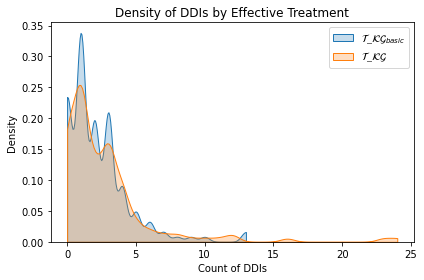

In [8]:
density_ddi(df_plot)